<a href="https://colab.research.google.com/github/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/blob/main/FIGURE_3_ABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A function for loading students dataset

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')
from os import listdir
from os.path import isfile, join, isdir
import networkx as nx
import sys
import logging
import pandas as pd
import random

shift=1000
def sample_from_dict(d, sample=10):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

def load_one_student_per_room(max_students, meaningful_pref, min_day, presources=-1, pagents=-1):

    apply_alone= False

    preferencesp = 'https://raw.githubusercontent.com/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/4aa44a991ef92b662f2a9081ba7860953f3f8e5c/data/Lab-Space-Dataset/student_preferences.csv'
    roomsp = 'https://raw.githubusercontent.com/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/4aa44a991ef92b662f2a9081ba7860953f3f8e5c/data/Lab-Space-Dataset/lab_rooms.csv'
    advisorsp = 'https://raw.githubusercontent.com/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/main/data/Lab-Space-Dataset/student_details.csv'
    prefs = {}
    rooms = {}

    df_prefs = pd.read_csv (preferencesp)
    df_rooms = pd.read_csv(roomsp )
    df_advisors = pd.read_csv(advisorsp)

    prefs = df_prefs.to_dict()
    rooms = df_rooms.to_dict()
    advisors = df_advisors.to_dict()
    #print(advisors)
    #print(rooms)
    #if presources>0:
    #   rooms = sample_from_dict(rooms,int(presources*len(rooms)))

    resource_attr = {}
    pref_attr = {}

    G = nx.Graph()

    left = set()
    right = set()

    for c, pid in enumerate(prefs['id']):
      if random.random()<pagents or pagents<0:
        left.add((c, pid))
        G.add_node(pid, bipartite=0)

    for r,rid in rooms['id'].items():
      if random.random()<presources or presources<0:
        right.add((r, rid+shift))
        G.add_node(rid+shift, bipartite=1)
    
    for j in range(1,max_students):
      for r,rid in rooms['id'].items():
          if rooms['size'][r] == 2 and rooms['seats'][r] >j:
            if random.random()<presources or presources<0:
              right.add((r, rid+(1+j) * shift))
              G.add_node(rid+(1+j)*shift, bipartite=1)

    fields = set()
    resource_attr = {}
    for rid in right:
        resource_attr[rid[1]]={}
        for  field in rooms:
            if field !='id':
                resource_attr[rid[1]][field] = rooms[field][rid[0]]
                fields.add(field)

    cost = {}
    final_fields = set()
    days = {}
    for pid in left:
      
        cost[pid[1]] = {}
        advisor = None
        near = None
        specific =False
        sp_number = None
        sp_level = None
        alone_level = None
        noise_level = None 

        ndays = None
        
        for field in prefs:
            if field in fields:
                final_fields.add(field)
               
                cost[pid[1]][field]={}
                for rrid,rid in rooms['id'].items():

                    cost[pid[1]][field][rid+shift] = 0 if rooms[field][rrid] >0 else max(prefs[field][pid[0]]-meaningful_pref+1,0) # if want, price for relaxation will be high

                    for j in range(1,max_students):
                      if (rid+((1+j)*shift )) in G.nodes():
                        cost[pid[1]][field][(rid+((1+j)*shift ))] = cost[pid[1]][field][rid+shift]

            advisor = advisors['advisor'][pid[0]]
 
            if field == 'near_advisor':
                near = prefs[field][pid[0]]
            if field == 'specific_room':
                specific = True if prefs[field][pid[0]]>0 else False
            if field == 'specific_room_number':
                sp_number = prefs[field][pid[0]]
            if field == 'specific_room_importance':
                sp_level = prefs[field][pid[0]]

            if field == 'alone':
                alone_level = prefs[field][pid[0]]
            if field == 'silent':
                silent_level = prefs[field][pid[0]]
            if field =='ndays':
                ndays = prefs[field][pid[0]]
            if field =='d1':
                sunday = prefs[field][pid[0]]>=min_day
            if field =='d2':
                monday = prefs[field][pid[0]]>=min_day
            if field =='d3':
                tuesday = prefs[field][pid[0]]>=min_day
            if field =='d4':
                wednesday = prefs[field][pid[0]]>=min_day
            if field =='d5':
                thursday = prefs[field][pid[0]]>=min_day
        
        days[pid[1]] = (ndays, [sunday,monday,tuesday, wednesday,thursday])

        field = None
        if advisor == 1:
            field = 'distance_to_advisor0'
        elif advisor == 2:
            field = 'distance_to_advisor1'

        if field is not None:

            cost[pid[1]]['advisor']={}
            for rrid,rid in rooms['id'].items():                    
                    cost[pid[1]]['advisor'][rid+shift] = 0 if rooms[field][rrid] >0 else max(near-meaningful_pref+1,0) # if want, price for relaxation will be high


                    for j in range(1,max_students):
                      if (rid+((1+j)*shift )) in G.nodes():
                        cost[pid[1]]['advisor'][(rid+((1+j)*shift ))] = cost[pid[1]]['advisor'][rid+shift]
        
        if specific:
            cost[pid[1]]['specific']={}
            field = 'id'
            for rrid,rid in rooms['id'].items():                    
                    cost[pid[1]]['specific'][rid+shift] = 0 if rooms[field][rrid] == sp_number  else max(sp_level-meaningful_pref+1,0) # if want, price for relaxation will be high
                    for j in range(1,max_students):
                      if (rid+((1+j)*shift )) in G.nodes():
                        cost[pid[1]]['specific'][(rid+((1+j)*shift ))] = cost[pid[1]]['specific'][rid+shift]

        else:
            cost[pid[1]]['specific']={}
            field = 'id'
            for rrid,rid in rooms['id'].items():                    
                    cost[pid[1]]['specific'][rid+shift] = 0
                    for j in range(1,max_students):
                      if (rid+((1+j)*shift )) in G.nodes():
                        cost[pid[1]]['specific'][(rid+((1+j)*shift ))] = cost[pid[1]]['specific'][rid+shift]
                      
        if apply_alone and alone_level is not None:
                cost[pid[1]]['alone']={}
                field = 'seats'
                for rrid,rid in rooms['id'].items():                    
                    cost[pid[1]]['alone'][rid+shift] = 0 if rooms[field][rrid] == 1   else max(alone_level-meaningful_pref+1,0) # if want, price for relaxation will be high
                    for j in range(1,max_students):
                      if (rid+((1+j)*shift )) in G.nodes():
                        cost[pid[1]]['alone'][(rid+((1+j)*shift ))] = cost[pid[1]]['alone'][rid+shift]

                
        if silent_level is not None:
                cost[pid[1]]['silent']={}
                field = 'distance_to_kitchen'
                for rrid,rid in rooms['id'].items():                    
                        cost[pid[1]]['silent'][rid+shift] = 0 if rooms[field][rrid] == 0  else max(silent_level-meaningful_pref+1,0) # if want, price for relaxation will be high
                        if (rid+(2*shift )) in G.nodes():
                            cost[pid[1]]['silent'][(rid+(2*shift ))] = cost[pid[1]]['silent'][rid+shift]
                        for j in range(1,max_students):
                          if (rid+((1+j)*shift )) in G.nodes():
                            cost[pid[1]]['silent'][(rid+((1+j)*shift ))] = cost[pid[1]]['silent'][rid+shift]
    room_failures = {}
    pool = {}

    for pid in cost:
        restricted = set()
        all_rooms = set()

        for fname, field in cost[pid].items():

            for room in field.items():
                all_rooms.add(room[0] )
                if room[1] > 0 :
                    restricted.add(room[0] )

        ls = tuple(sorted(list(all_rooms-restricted)))
        if  ls not in pool:
            pool[ls] = [pid]
        else:
            pool[ls].append(pid)

        for room_id in all_rooms-restricted:
            if room_id in G.nodes():
              G.add_edge(pid, room_id)

    attributes = set()
    for item in cost.items():
        break
    for item in cost.values():
        for key in item:
            attributes.add(key)
    #print(max_students,len(left),len(right) )
    #print(len(left))
  

    return G, len(left),len(right),cost, attributes, days


#G, n, m, cost, attributes, days = load_one_student_per_room()

import numpy as np


def get_delta1(G,days):
  delta = {}
  k = len(next(iter(days.values()))[1])
  values = set()
  for i in range(k+1):
    for j in range(k+1):
      if i<=j and j>0:
        values.add(i/j)
  ls = sorted(list(values), key=lambda x: -x)
  ord = {}
  for c,item in enumerate(ls):
    ord[item] = c
  xi = {}
  for item in ls:
    xi[item] = (k*n)**ord[item]
    #print(xi[item])
  mx = max(xi.values())
  agents = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
  for agent in agents:
    rho = days[agent][0]
    delta[agent] = {}
    for i in range(1, rho+1):
        delta[agent][i]=xi[(i-1)/rho]
 # print("mn mx " , min(xi.values()),max(xi.values()))
  return delta, max(xi.values())

def get_delta2(G,days):
  delta = {}
  k = len(next(iter(days.values()))[1])
  agents = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
  for agent in agents:
    rho = days[agent][0]
    delta[agent] = {}
    for i in range(1, rho+1):
        delta[agent][i]=1
 # print(delta)
  return delta,1

def run_for_parameters(G, n, m, days, delta = 2):
  
  k = len(next(iter(days.values()))[1])
  agents =    {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
  resources = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
  
  for i,agent in enumerate(agents):
    G.nodes[agent]['rho'] = days[agent][0]

  #generate the auxilary graph
  G_construction = nx.Graph()
  #for each resource in original graph, add k resources, one per matching round
  for resource in resources:
    for i in range(1,k+1):
      res = str(resource) +"_" + str(i)
      G_construction.add_node(res, bipartitie=1)
  kis = {}

  #for each agent in original graph, add k agents in auxilary
  for agent in agents:
    relevant_days = days[agent][1]
    ki = 0

    for i in range(1,k+1):
      if not relevant_days[i-1]:
        continue
      ki += 1
      ag = str(agent) +"-" + str(i)
      G_construction.add_node(ag, bipartitie=0)
    kis[agent] = ki
    rho = G.nodes[agent]['rho']
    #add type 2 dummy resources, with total of rho.
    for j in range( 1, rho+1 ):
      ag = "x-" + str(agent) +"_"+str(j)
      G_construction.add_node(j,bipartite=1)

    #add type 3 dummy resources, one per unmatched round of an agent
    for j in range( 1, ki-rho+1 ):
      ag = "z-" + str(agent) +"_"+str(j)
      G_construction.add_node(j,bipartite=1)

  verbose = False
  el = []

# print("total edges are ", len(el))
  #add edges to type 3 dummy resources
  bign = k+1
  if delta==1:
    delta, mx = get_delta1(G,days)
  elif delta==2:
    delta,mx = get_delta2(G,days)

  #print(mx)
  #add edges of original graph to auxilary
  for agent in agents:
    if agent == 2:
      verbose = True
    for resource in resources:
      if (agent,resource) not in G.edges() and (resource,agent) not in G.edges():
        continue
      relevant_days = days[agent][1]
      for i in range(1,k+1):
          if relevant_days[i-1]:
            edge = (str(agent) +"-" + str(i),  str(resource) +"_" + str(i))
            if verbose:
              el.append(edge)
            G_construction.add_edge(edge[0], edge[1], weight=mx)
    verbose = False

  for agent in agents:
    relevant_days = days[agent][1]
    for i in range(1,k+1):
      if relevant_days[i-1]:
        rho = G.nodes[agent]['rho']
        for j in range( 1, rho+1 ):
          ag = "x-" + str(agent) +"_"+str(j)
          try:
            G_construction.add_edge(str(agent) +"-" + str(i), ag,weight=(mx-delta[agent][j]))
          except Exception as e:
            print("Exception")
            print("GOT AN EXCEPTION WHEN ADDING EDGE", rho, j, delta[agent])

        for j in range( 1, kis[agent]-rho+1 ):
          ag = "z-" + str(agent) +"_"+str(j)
          G_construction.add_edge(str(agent) +"-" + str(i), ag,weight=bign*mx)
          

  #calculate weighted matching
  matching = nx.max_weight_matching(G_construction, weight='weight')
  #print(matching)

  #Given the resulting matching, construct k matchings in original graph
  ret = []
  for l in range(k):
        ret.append(set())

  agent_assignments = {}

  #print(matching)
  for (x,y) in matching:
      if "z-" in y or 'z-' in x or "x-" in y or 'x-' in x:
        continue
      else:
        if '-' in x: #sign for an agent
          agent = x
          resource = y
        else:
          agent = y
          resource = x
        place = int(agent.split('-')[1]) - 1
        ag = agent.split('-')[0]
        ret[place].add((ag,resource.split("_")[0]))
  

  return agents, resources, G, ret



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Given the students dataset and graph run the max total algorithm

A wrapper for showing the graphs

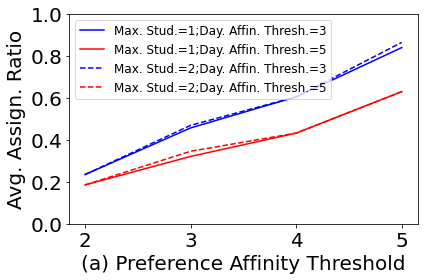

In [19]:
import networkx as nx
from random import choices
import matplotlib.pyplot as plt
import copy
import math

grp = {}
edges = 0 
agn = 0

for max_students_per_room in range(1,6):
  for meaningful_pref in range(1,7):
    for meaningful_day_pref in range(1,6):
      total = 0
      G, n, m, cost, attributes, days = load_one_student_per_room(max_students_per_room, meaningful_pref, meaningful_day_pref)
      for agent in days:
        total += days[agent][0]
      agents, resources, G, ret = run_for_parameters(G, n, m, days)
      if max_students_per_room not in grp:
        grp[max_students_per_room] = {}
      if meaningful_pref not in grp[max_students_per_room]:
        grp[max_students_per_room][meaningful_pref] = {}  
      if meaningful_day_pref not in grp[max_students_per_room][meaningful_pref]:

        sm = 0
        for item in ret:
          sm += len(item)
          
        grp[max_students_per_room][meaningful_pref][meaningful_day_pref] = sm/total

#print(grp)

x = [2,3,4,5]

labels = []

ys = []
for students in range(1,3):
  for day in range(3,6,2):
    y = [grp[students][xx][day] for xx in x]
    y.insert(0,"st-{}day-{}".format(students,day))
    ys.append(y)

# seaborn plot multiple lines

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import os

df = pd.DataFrame(ys, columns = ['name',2,3,4,5])
df2 = df.transpose()

new_header = df2.iloc[0] #grab the first row for the header
df2 = df2[1:] #take the data less the header row
df2.columns = new_header #set the header row as the df header
df2['x'] = df2.index

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1 = sns.lineplot(x='x', y='st-1day-3', data=df2, color='blue', label="Max. Stud.={};Day. Affin. Thresh.={}".format(1,3), linestyle="solid")
ax2 = sns.lineplot(x='x', y='st-1day-5', data=df2, color='red', label="Max. Stud.={};Day. Affin. Thresh.={}".format(1,5), linestyle="solid")
ax3 = sns.lineplot(x='x', y='st-2day-3', data=df2, color = 'blue', label="Max. Stud.={};Day. Affin. Thresh.={}".format(2,3), linestyle="dashed")
ax4 = sns.lineplot(x='x', y='st-2day-5', data=df2, color = 'red', label="Max. Stud.={};Day. Affin. Thresh.={}".format(2,5), linestyle="dashed")

ax.set_xlabel("(a) Preference Affinity Threshold", fontsize = 20)
ax.set_ylabel("Avg. Assign. Ratio", fontsize = 20)
ax.legend(fontsize='large', title_fontsize='20')

plt.xticks(fontsize=20 )
plt.yticks([0.0, 0.2,0.4,0.6,0.8,1.0],fontsize=20 )

path = "/content/gdrive/My Drive/students_lab_results"
isExist = os.path.exists(path)

if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)

plt.tight_layout()
plt.savefig(join(path,"StudMnPref.pdf"), format="pdf")

plt.show()


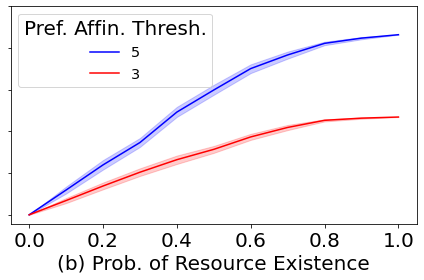

In [18]:
import networkx as nx
from random import choices
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns
import numpy as np

retp1 = []
retp2 = []

for l in range(100):
  for percent in np.arange (0.0, 1.1, 0.1):
        G, n, m, cost, attributes, days = load_one_student_per_room(2, 5, 3, percent)
        agents, resources, G, ret = run_for_parameters(G, n, m, days)
        total = 0
        for agent in days:
                total += days[agent][0]
        v =0
        for st in ret:
          v+=len(st)
        v /= total
        
        retp1.append((percent,v))

        G, n, m, cost, attributes, days = load_one_student_per_room(2, 3, 3, percent)
        agents, resources, G, ret = run_for_parameters(G, n, m, days)
        total = 0
        for agent in days:
                total += days[agent][0]
        v =0
        for st in ret:
          v+=len(st)
        v /= total
        
        retp2.append((percent,v))

df1 = pd.DataFrame(retp1, columns =['percent',  'avg'])
df2 = pd.DataFrame(retp2, columns =['percent',  'avg'])

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1 = sns.lineplot(x='percent', y='avg', data=df1,label="5", color='blue', linestyle="solid")
ax2 = sns.lineplot(x='percent', y='avg', data=df2,label="3", color='red', linestyle="solid")

ax.set_xlabel("(b) Prob. of Resource Existence", fontsize = 20)
#ax.set_ylabel("Avg. Assign. Ratio", fontsize = 20)
ax.set_ylabel("", fontsize = 20)

ax.legend(title='Pref. Affin. Thresh.', fontsize='x-large', title_fontsize='20')

plt.xticks([0.0, 0.2,0.4,0.6,0.8,1.0], fontsize=20 )
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=20 )
ax.set_yticklabels([])
#plt.yticks(fontsize=20 )

path = "/content/gdrive/My Drive/students_lab_results"
import os

isExist = os.path.exists(path)

if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)

plt.tight_layout()
plt.savefig(join(path,"StudPrb.pdf"), format="pdf")




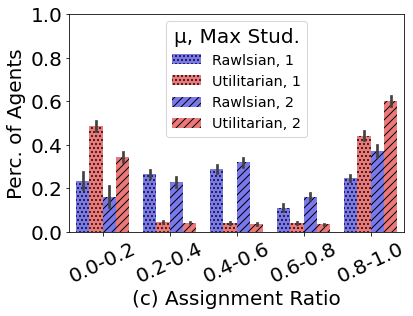

In [ ]:
import networkx as nx
from random import choices
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns
import numpy as np

def ratio_range2(x):
  if x <= 0.2:
    return "0.0-0.2"
  elif x<=0.4:
    return "0.2-0.4"
  elif x<=0.6:
    return "0.4-0.6"
  elif x<=0.8:
    return "0.6-0.8"
  elif x<=1.0:
    return "0.8-1.0"

def ratio_range(x):
  if x <= 0.1:
    return "0.0-0.1"
  elif x<=0.2:
    return "0.1-0.2"
  elif x<=0.3:
    return "0.2-0.3"
  elif x<=0.4:
    return "0.3-0.4"
  elif x<=0.5:
    return "0.4-0.5"
  elif x <= 0.6:
    return "0.5-0.6"
  elif x<=0.7:
    return "0.6-0.7"
  elif x<=0.8:
    return "0.7-0.8"
  elif x<=0.9:
    return "0.8-0.9"
  elif x<=1.0:
    return "0.9-1.0"
yall=[]
expe = 100
for exp in range(expe):
  for stud in range(1,3):
      for pref in range(5,6):
        for dpref in range(2,3):
          for agperc in [1.0]:
            y = []
            G, n, m, cost, attributes, days = load_one_student_per_room(stud, pref,dpref, 0.5, 1.0)
            agents, resources, G, ret1 = run_for_parameters(G, n, m, days,delta=1)
            agents, resources, G, ret2 = run_for_parameters(G, n, m, days,delta=2)

            times_per_agent = {}

            for lst in ret1:
              for pair in lst:
                if int(pair[0]) not in times_per_agent:
                  times_per_agent[int(pair[0])] = 1
                else:
                  times_per_agent[int(pair[0])] += 1

            sum = 0
            num = 0
            for agent in times_per_agent:
              sum += times_per_agent[agent] 
              num +=1

            for agent in agents:
              if agent not in times_per_agent:
                times_per_agent[agent]=0

            for agent in times_per_agent:
                ratio = times_per_agent[agent]/days[int(agent)][0]
                y.append(('Rawlsian',days[int(agent)][0],ratio,sum))
            #print("t1", times_per_agent)
            times_per_agent = {}
            for lst in ret2:
              for pair in lst:
                if int(pair[0]) not in times_per_agent:
                  times_per_agent[int(pair[0])] = 1
                else:
                  times_per_agent[int(pair[0])] += 1
            for agent in agents:
              if agent not in times_per_agent:
                times_per_agent[agent]=0
            
            for agent in times_per_agent:
                ratio = times_per_agent[agent]/days[int(agent)][0]
                y.append(('Utilitarian',days[int(agent)][0],ratio,sum))
            #print("t2",times_per_agent)

            yp = {}
            for item in y:
              if item[0] not in yp:
                yp[item[0]] = {}
              if item[2] not in yp[item[0]]:
                yp[item[0]][item[2]] = 1
              else:
                yp[item[0]][item[2]] += 1
            
            for item in yp:
              for item2 in yp[item]:
#                print(item, item2, ratio_range2(item2))
                yall.append((item,stud,exp, ratio_range2(item2), yp[item][item2]))

#print(yall)

df = pd.DataFrame(yall, columns =['Delta', 'stud','exp', 'Ratio', 'Num'])
ord = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]
df = df.sort_values(by='Ratio', key=lambda x: df["Ratio"])
df_grp = df.groupby(['Ratio','exp','Delta','stud'])['Num'].sum().reset_index()

df_grp['Perc'] = df_grp['Num']/ len(agents)


import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

hue = df_grp['Delta'].astype(str) + ', ' + df_grp['stud'].astype(str)

ax = sns.barplot( x="Ratio", y="Perc", hue_order=['Rawlsian, 1','Utilitarian, 1','Rawlsian, 2','Utilitarian, 2'], hue=hue, data=df_grp, palette=["blue","red"], alpha=.6)

ax.set_xlabel("(c) Assignment Ratio", fontsize=20)
ax.set_ylabel("Perc. of Agents",fontsize=20)
ax.get_legend().remove()

import itertools
hatches = itertools.cycle(['...', '...', '///', '///'])
for i, bar in enumerate(ax.patches):
    if i % 5 == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)

plt.legend(title="μ, Max Stud.", fontsize='x-large', title_fontsize='20')
plt.xticks(fontsize=20,rotation=25 )
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=20 )
import os

path = "/content/gdrive/My Drive/students_lab_results"
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)
plt.savefig(join(path,"StdRatioBar3.pdf"), format="pdf",bbox_inches='tight')
